In [1]:
import os
import pandas as pd
import numpy as np

from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings

warnings.filterwarnings("ignore")

from alpaca_trade_api.rest import REST, TimeFrame

from transformers import pipeline

os.environ["APCA_API_KEY_ID"] = "PKT7L7DB0P70Q6EC6LCS"
os.environ["APCA_API_SECRET_KEY"] = "G1EvCzuNZlk9SZ1bDQGYch0cKcL5APKeQMRg8FLU"
os.environ["APCA_API_DATA_URL"] = "https://data.alpaca.markets"
os.environ["APCA_RETRY_MAX"] = "3"
os.environ["APCA_RETRY_CODES"] = "429,504"

for key, val in os.environ.items():
    if "APCA" in key:
        print(key, val)

APCA_API_KEY_ID PKT7L7DB0P70Q6EC6LCS
APCA_API_SECRET_KEY G1EvCzuNZlk9SZ1bDQGYch0cKcL5APKeQMRg8FLU
APCA_API_DATA_URL https://data.alpaca.markets
APCA_RETRY_MAX 3
APCA_RETRY_CODES 429,504


In [2]:
STOCK = "TSLA"
START_DATE = "2019-11-15"
END_DATE = "2023-11-15"

In [3]:
def get_stock_news_data(
    stock, startDate, endDate, adjustment="raw", confidenceScore=0.85
):
    api = REST()

    stockData = api.get_bars(
        stock, TimeFrame.Day, startDate, endDate, adjustment=adjustment
    ).df

    stockData.info()

    stockData.plot(subplots=True, figsize=(8, 8))
    plt.show()

    date = startDate
    news = []
    while date <= endDate:
        nextdate = (pd.to_datetime(date) + pd.Timedelta("1 day")).strftime("%Y-%m-%d")
        news.extend(
            api.get_news(
                stock,
                date,
                nextdate,
                limit=5,
            )
        )

        date = nextdate

    classifier = pipeline("sentiment-analysis", model="ProsusAI/finbert")
    newsList = []

    for i in range(len(news)):
        sentiment = classifier(news[i].headline.strip() + " " + news[i].summary.strip())
        newsList.append(
            [news[i].created_at, sentiment[0]["label"], round(sentiment[0]["score"], 2)]
        )

    newsDF = pd.DataFrame(
        newsList,
        columns=["timestamp", "label", "score"],
    )
    newsDF["timestamp"] = pd.to_datetime(
        newsDF["timestamp"], errors="coerce", format="%Y-%m-%d %H:%M:%S", utc=True
    )
    newsDF.set_index("timestamp", inplace=True)

    newsDF = newsDF[newsDF["score"] > confidenceScore]
    aggDF = newsDF.groupby([newsDF.index.date, "label"]).size().unstack(fill_value=0)

    data = stockData.join(aggDF, on=stockData.index.date, how="left").fillna(0)

    return data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2019-11-15 05:00:00+00:00 to 2023-11-15 05:00:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        1007 non-null   float64
 1   high         1007 non-null   float64
 2   low          1007 non-null   float64
 3   trade_count  1007 non-null   int64  
 4   open         1007 non-null   float64
 5   volume       1007 non-null   int64  
 6   vwap         1007 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 62.9 KB


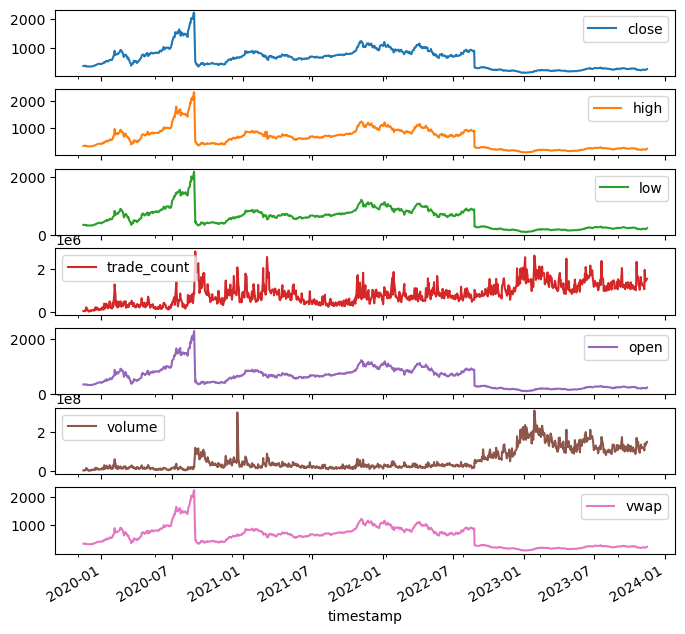

sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...


In [4]:
dataTSLA = get_stock_news_data(STOCK, START_DATE, END_DATE)

In [5]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_white"

In [6]:
def plot_close_news(data):
    linePlot = make_subplots(specs=[[{"secondary_y": True}]])

    linePlot.add_trace(
        go.Scatter(x=data.index, y=data["close"], name="Price"), secondary_y=False
    )

    linePlot.add_trace(
        go.Bar(x=data.index, y=data["negative"], name="Negative"), secondary_y=True
    )

    linePlot.add_trace(
        go.Bar(x=data.index, y=data["positive"], name="Positive"), secondary_y=True
    )

    linePlot.add_trace(
        go.Bar(x=data.index, y=data["neutral"], name="Neutral"), secondary_y=True
    )

    # linePlot.update_traces(marker_line_width=0, selector=dict(type="bar"))

    linePlot.update_layout(
        bargap=0,
        bargroupgap=0,
    )

    linePlot.show()


plot_close_news(dataTSLA)

In [7]:
dataTSLA["diff"] = dataTSLA["open"] - dataTSLA["close"]


dataTSLA["diff"] = dataTSLA["diff"].apply(lambda x: "neg" if x < 0 else "pos")


scatterPlot = px.scatter(
    dataTSLA,
    x=dataTSLA.index,
    y="close",
    color="diff",
)


# scatterPlot.update_xaxes(
#     # rangeslider_visible=True,
# #     rangebreaks=[
# #         dict(bounds=["sat", "mon"]),
# #     ],
# )


scatterPlot.show()

In [8]:
candlestickPlot = go.Figure(
    data=[
        go.Candlestick(
            x=dataTSLA.index,
            open=dataTSLA["open"],
            high=dataTSLA["high"],
            low=dataTSLA["low"],
            close=dataTSLA["close"],
        )
    ]
)
candlestickPlot.update_layout(
    title="Candlestick chart for " + STOCK,
    xaxis_title="Date",
    yaxis_title="Price ($USD)",
    xaxis_rangeslider_visible=False,
    shapes=[
        dict(
            x0="2022-08-25",
            x1="2022-08-25",
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0="2020-08-31",
            x1="2020-08-31",
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
    ],
    annotations=[
        dict(
            x="2022-08-25",
            y=0.5,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Stock split 3:1",
        ),
        dict(
            x="2020-08-31",
            y=0.05,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Stock split 5:1",
        ),
    ],
)

candlestickPlot.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]),
    ]
)
candlestickPlot.show()

In [9]:
pvPlot = make_subplots(specs=[[{"secondary_y": True}]])
pvPlot.add_trace(
    go.Scatter(x=dataTSLA.index, y=dataTSLA["close"], name="Price"), secondary_y=False
)
pvPlot.add_trace(
    go.Bar(x=dataTSLA.index, y=dataTSLA["volume"], name="Volume"), secondary_y=True
)
pvPlot.update_traces(marker_line_width=0, selector=dict(type="bar"))
# marker_color="#316395"
pvPlot.update_layout(
    title="Scatter plot of price with volume",
    bargap=0,
    bargroupgap=0,
)
pvPlot.show()

In [10]:
ma = "30"
pvMAPlot = make_subplots(specs=[[{"secondary_y": True}]])


pvMAPlot.add_trace(
    go.Scatter(
        x=dataTSLA.index,
        y=dataTSLA["close"].rolling(window=int(ma)).mean(),
        marker_color="blue",
        name=ma + " Day MA",
    )
)
pvMAPlot.add_trace(
    go.Bar(x=dataTSLA.index, y=dataTSLA["volume"], name="Volume"), secondary_y=True
)
pvMAPlot.update_layout(title={"text": STOCK, "x": 0.5})

# fig3.update_yaxes(visible=False, secondary_y=True)
pvMAPlot.update_layout(
    title=ma + " days moving average for price with volume",
    xaxis_rangeslider_visible=False,
    bargap=0,
    bargroupgap=0,
)

pvMAPlot.update_traces(
    marker_color="rgb(82, 106, 131)", marker_line_width=0, selector=dict(type="bar")
)

pvMAPlot.show()

In [11]:
avgHist = px.histogram(
    dataTSLA,
    x=dataTSLA.index,
    y="close",
    histfunc="avg",
    title="Histogram wrt to months for closing price",
)
avgHist.update_traces(xbins_size="M1")
avgHist.update_xaxes(
    showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y"
)
avgHist.update_layout(bargap=0.1)
avgHist.add_trace(
    go.Scatter(mode="markers", x=dataTSLA.index, y=dataTSLA["close"], name="daily")
)
avgHist.show()

In [12]:
corr = dataTSLA[["close", "open", "positive", "negative", "neutral", "volume"]].corr(
    numeric_only=True
)
heatmap = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale=("red", "white", "blue"),
    template="ggplot2",
)

heatmap.update_xaxes(side="top")
heatmap.layout.height = 600
heatmap.layout.width = 600

heatmap.show()

In [13]:
finalDataTSLA = dataTSLA[["close", "positive", "negative", "neutral"]]
# finalDataTSLA['residuals'] = finalDataTSLA['close'].diff()
# finalDataTSLA.drop(['close'], axis = 1, inplace=True)
# finalDataTSLA.dropna(axis=0, inplace=True)

# finalData["residuals"] = finalData["residuals"].apply(lambda x: 1 if x >= 0 else 0)

finalDataTSLA[["positive", "negative", "neutral"]] = finalDataTSLA[
    ["positive", "negative", "neutral"]
].astype(int)
finalDataTSLA

,close,positive,negative,neutral
timestamp,,,,
2019-11-15 05:00:00+00:00,352.17,0,0,1
2019-11-18 05:00:00+00:00,349.99,0,0,2
2019-11-19 05:00:00+00:00,359.52,0,0,3
2019-11-20 05:00:00+00:00,352.22,1,0,2
2019-11-21 05:00:00+00:00,354.83,0,0,0
...,...,...,...,...
2023-11-09 05:00:00+00:00,209.98,1,1,0
2023-11-10 05:00:00+00:00,214.65,2,1,2
2023-11-13 05:00:00+00:00,223.71,1,1,1


In [14]:
window = 60


batchSize = 30

features = finalDataTSLA.shape[1]


hiddenSize = 64

inputSize = 4

outputSize = 1

layerSize = 2

learningRate = 0.001

weightDecay = 1e-5

dropoutRate = 0.2


epochs = 20

In [15]:
def create_sequences(data, window):
    sequences, targets = [], []

    for i in range(len(data) - window):
        sequence = data[i : i + window]
        target = data[i + window][0]

        sequences.append(sequence)
        targets.append(target)

    return (
        torch.tensor(np.array(sequences)).float(),
        torch.tensor(np.array(targets)).float(),
    )

In [16]:
import torch.utils.data as dataL
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def preproc_data(data, window, batchSize):
    trainValSet, testSet = np.split(data, [int(0.69 * len(data))])
    trainSet, valSet = np.split(trainValSet, [int(0.70 * len(trainValSet))])

    scaler = StandardScaler()

    trainSetScaled = scaler.fit_transform(trainSet)
    valSetScaled = scaler.transform(valSet)
    testSetScaled = scaler.transform(testSet)

    xTrain, yTrain = create_sequences(trainSetScaled, window)
    xVal, yVal = create_sequences(valSetScaled, window)
    xTest, yTest = create_sequences(testSetScaled, window)

    trainLoader = dataL.DataLoader(
        dataL.TensorDataset(xTrain, yTrain),
        shuffle=False,
        batch_size=batchSize,
        drop_last=True,
    )
    valLoader = dataL.DataLoader(
        dataL.TensorDataset(xVal, yVal),
        shuffle=False,
        batch_size=batchSize,
        drop_last=True,
    )

    testLoader = dataL.DataLoader(
        dataL.TensorDataset(xTest, yTest),
        shuffle=False,
        batch_size=batchSize,
        drop_last=True,
    )

    return trainLoader, valLoader, testLoader, scaler, testSet.index

In [17]:
(
    trainLoaderTSLA,
    valLoaderTSLA,
    testLoaderTSLA,
    scalerTSLA,
    testIndexTSLA,
) = preproc_data(finalDataTSLA, window, batchSize)

In [18]:
import torch
import torch.nn.functional as F

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def calc_metrics(yTrue, yPred):
    metrics = {}

    metrics["mae"] = round(mean_absolute_error(yTrue, yPred), 4)
    metrics["rmse"] = round(np.sqrt(mean_squared_error(yTrue, yPred)), 4)

    return metrics

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    numBatches = len(dataloader)
    model.train()
    trainLoss = 0
    for batch, (seqs, targets) in enumerate(dataloader):
        seqs = seqs.view([batchSize, -1, features]).to(device)
        seqs, targets = seqs.to(device), targets.to(device)

        optimizer.zero_grad()

        if len(seqs) == batchSize:
            pred = model(seqs)
            # print(pred.shape, targets.shape)
            loss = loss_fn(pred, targets)

            loss.backward()
            optimizer.step()

            trainLoss += loss.item()
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    trainLoss /= numBatches

    return round(trainLoss, 4)

In [36]:
def test(dataloader, model, loss_fn, check=False):
    # size = len(dataloader.dataset)
    testPred = []
    testTrue = []
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for seqs, targets in dataloader:
            seqs = seqs.view([batchSize, -1, features]).to(device)
            seqs, targets = seqs.to(device), targets.to(device)
            testTrue.extend(targets.tolist())

            if len(seqs) == batchSize:
                pred = model(seqs)
                test_loss += loss_fn(pred, targets).item()
                testPred.extend(pred.tolist())
                # correct += (pred == targets).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size

    if check:
        print(calc_metrics(testTrue, testPred))
    return {"val_loss": round(test_loss, 4)}

In [37]:
def fit_and_evaluate(model, trainl, testl, loss_fn, optimizer, epochs=10):
    trainLosses = []
    testLosses = []
    results = []

    for t in range(epochs):
        if (t + 1) % 5 == 0:
            print(f"Epoch {t+1}")
        trainLoss = train(trainl, model, loss_fn, optimizer)

        testDict = test(testl, model, loss_fn)
        testLoss = testDict["val_loss"]

        trainLosses.append(trainLoss)
        testLosses.append(testLoss)
        results.append({"train_loss": trainLoss, "val_loss": testLoss})

    print("------------------")
    print(f"Test Error: \n Avg loss: {round(np.mean(testLosses), 4)} \n")

    return results

In [38]:
def plot_curves(history, epochs, acc=False):
    trainLosses = [x["train_loss"] for x in history]
    testLosses = [x["val_loss"] for x in history]

    # trainAccuracies = [i["accuracy"] for i in trainMetrics]
    # testAccuracies = [x["val_acc"] for x in history]

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss curve")
    plt.xticks = range(1, epochs + 1)
    plt.locator_params(axis="x", integer=True)

    plt.plot(
        range(1, epochs + 1), trainLosses, label="Training loss", linestyle="dotted"
    )
    plt.plot(range(1, epochs + 1), testLosses, label="Test loss")

    # plt.plot(range(1, epochs + 1), trainAccuracies, label="Training accuracy")
    # plt.plot(range(1, epochs + 1), testAccuracies, label="Test accuracy")

    plt.legend()
    plt.show()

In [82]:
yValsTSLA = []
for seqs, target in valLoaderTSLA:
    yValsTSLA.extend(target.tolist())

baselinePredsTSLA = [np.mean(yValsTSLA)] * len(yValsTSLA)

baselineMetricsTSLA = calc_metrics(yValsTSLA, baselinePredsTSLA)
baselineMetricsTSLA

{'mae': 0.3404, 'rmse': 0.4003}

In [39]:
class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0):
        super(RNNNet, self).__init__()

        self.hiddenDim = hidden_dim
        self.layerdim = layer_dim

        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True,
            dropout=dropout_prob,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(
            self.layerdim, x.size(0), self.hiddenDim, device=x.device
        ).requires_grad_()

        out, h0 = self.rnn(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)
        out = out.squeeze()

        return out

In [40]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0):
        super(LSTMNet, self).__init__()
        self.hiddenDim = hidden_dim
        self.layerdim = layer_dim

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=layer_dim,
            batch_first=True,
            dropout=dropout_prob,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(
            self.layerdim, x.size(0), self.hiddenDim, device=x.device
        ).requires_grad_()
        c0 = torch.zeros(
            self.layerdim, x.size(0), self.hiddenDim, device=x.device
        ).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = out[:, -1, :]

        out = self.fc(out)
        out = out.squeeze()

        return out

In [41]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0):
        super(GRUNet, self).__init__()

        self.layerDim = layer_dim
        self.hiddenDim = hidden_dim

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            layer_dim,
            batch_first=True,
            dropout=dropout_prob,
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(
            self.layerDim, x.size(0), self.hiddenDim, device=x.device
        ).requires_grad_()

        out, _ = self.gru(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)
        out = out.squeeze()

        return out

In [42]:
def training(
    trainLoader,
    valLoader,
    inputSize,
    hiddenSize,
    layerSize,
    outputSize,
    dropoutRate,
    learningRate,
    weightDecay,
    epochs=20,
):
    criterion = nn.MSELoss()
    print("Training vanilla RNN network")

    rnnNet = RNNNet(inputSize, hiddenSize, layerSize, outputSize, dropoutRate)

    rnnOptimizer = optim.Adam(
        rnnNet.parameters(), lr=learningRate, weight_decay=weightDecay
    )

    rnnNetHistory = []

    rnnNetHistory += fit_and_evaluate(
        rnnNet, trainLoader, valLoader, criterion, rnnOptimizer, epochs
    )

    plot_curves(rnnNetHistory, epochs)

    print("Training LSTM network")

    lstmNet = LSTMNet(inputSize, hiddenSize, layerSize, outputSize, dropoutRate)

    lstmOptimizer = optim.Adam(
        lstmNet.parameters(), lr=learningRate, weight_decay=weightDecay
    )

    lstmNetHistory = []

    lstmNetHistory += fit_and_evaluate(
        lstmNet, trainLoader, valLoader, criterion, lstmOptimizer, epochs
    )

    plot_curves(lstmNetHistory, epochs)

    print("Training GRU network")

    gruNet = GRUNet(inputSize, hiddenSize, layerSize, outputSize, dropoutRate)

    gruOptimizer = optim.Adam(
        gruNet.parameters(), lr=learningRate, weight_decay=weightDecay
    )

    gruNetHistory = []

    gruNetHistory += fit_and_evaluate(
        gruNet, trainLoader, valLoader, criterion, gruOptimizer, epochs
    )

    plot_curves(gruNetHistory, epochs)

    return rnnNet, lstmNet, gruNet

Training vanilla RNN network


Epoch 5
Epoch 10
Epoch 15
Epoch 20
------------------
Test Error: 
 Avg loss: 0.0507 



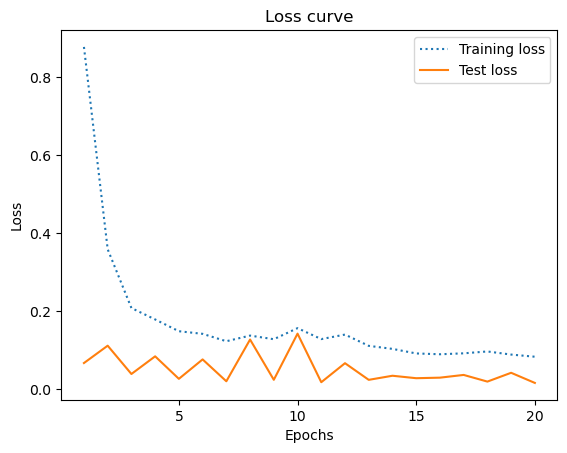

Training LSTM network
Epoch 5
Epoch 10
Epoch 15
Epoch 20
------------------
Test Error: 
 Avg loss: 0.1125 



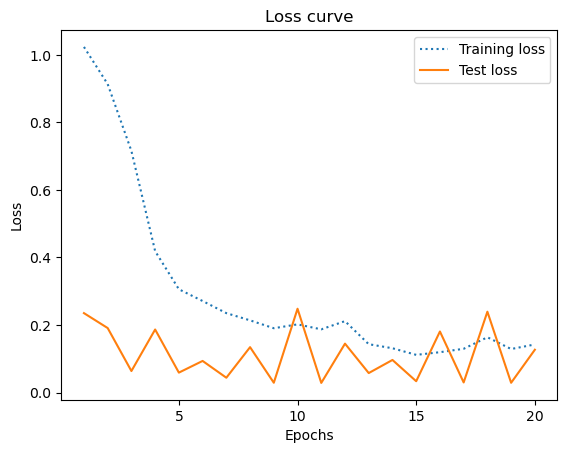

Training GRU network
Epoch 5
Epoch 10
Epoch 15
Epoch 20
------------------
Test Error: 
 Avg loss: 0.0623 



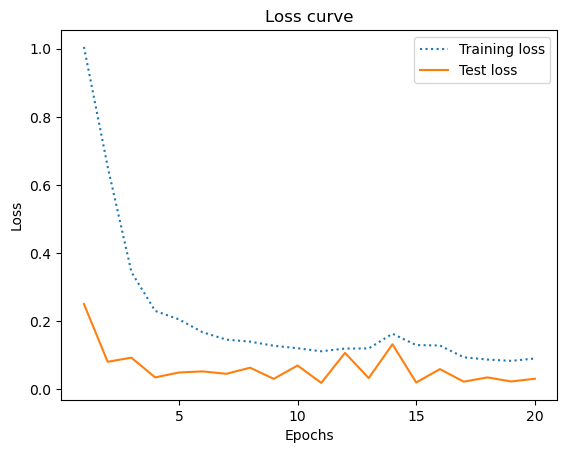

In [43]:
rnnNetTSLA, lstmNetTSLA, gruNetTSLA = training(
    trainLoaderTSLA,
    valLoaderTSLA,
    inputSize,
    hiddenSize,
    layerSize,
    outputSize,
    dropoutRate,
    learningRate,
    weightDecay,
    epochs,
)

In [44]:
def inference(model, testLoader, scaler, testIndex):
    with torch.no_grad():
        predictions = []
        trueValues = []
        for seqs, targets in testLoader:
            seqs = seqs.view([batchSize, -1, features]).to(device)
            targets = targets.to(device)
            model.eval()
            yPred = model(seqs)
            yPred = yPred.cpu().data.numpy()
            predictions.append(yPred)
            targets = targets.cpu().data.numpy()
            trueValues.append(targets)

    trues = np.concatenate(trueValues, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()

    predsDF = pd.DataFrame(
        data={"target": trues, "prediction": preds},
        index=testIndex[window : len(trues) + window],
    )

    for col in predsDF.columns:
        colValues = predsDF[col].to_numpy()
        colValues = np.c_[
            colValues,
            np.zeros(len(colValues)),
            np.zeros(len(colValues)),
            np.zeros(len(colValues)),
        ]
        colValuesIT = scaler.inverse_transform(colValues)
        predsDF[col] = colValuesIT[:, 0]

    metrics = calc_metrics(predsDF["target"], predsDF["prediction"])
    print(metrics)

    return predsDF, metrics

In [49]:
test(valLoaderTSLA, rnnNetTSLA, nn.MSELoss(), check=True)

{'mae': 0.1003, 'rmse': 0.1227}


{'val_loss': 0.0151}

In [50]:
test(valLoaderTSLA, lstmNetTSLA, nn.MSELoss(), check=True)

{'mae': 0.2706, 'rmse': 0.356}


{'val_loss': 0.1267}

In [51]:
test(valLoaderTSLA, gruNetTSLA, nn.MSELoss(), check=True)

{'mae': 0.1414, 'rmse': 0.1748}


{'val_loss': 0.0306}

In [56]:
testDataPreds, testMetrics = inference(
    rnnNetTSLA, testLoaderTSLA, scalerTSLA, testIndexTSLA
)

{'mae': 94.6163, 'rmse': 97.0732}


In [57]:
testDataPreds, testMetrics = inference(
    gruNetTSLA, testLoaderTSLA, scalerTSLA, testIndexTSLA
)

{'mae': 38.7881, 'rmse': 41.6092}


In [58]:
# plt.figure(figsize=(25, 5))
# plt.plot(finalDataTSLA["close"])

# plt.plot(testDataPreds["target"], c="r")


# plt.plot(testDataPreds["prediction"], c="g")


# plt.show()

predPlot = make_subplots(specs=[[{"secondary_y": True}]])


predPlot.add_trace(
    go.Scatter(
        x=finalDataTSLA.index[-300:],
        y=finalDataTSLA["close"][-300:],
        marker_color="blue",
        name=STOCK + " Clasing price",
    )
)
predPlot.add_trace(
    go.Scatter(x=testDataPreds.index, y=testDataPreds["target"], name="Target"),
    secondary_y=False,
)
predPlot.add_trace(
    go.Scatter(x=testDataPreds.index, y=testDataPreds["prediction"], name="Prediction"),
    secondary_y=False,
)

predPlot.update_layout(
    title="Stock price prediction for " + STOCK,
)


predPlot.show()

# NVDA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2019-11-15 05:00:00+00:00 to 2023-11-15 05:00:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        1007 non-null   float64
 1   high         1007 non-null   float64
 2   low          1007 non-null   float64
 3   trade_count  1007 non-null   int64  
 4   open         1007 non-null   float64
 5   volume       1007 non-null   int64  
 6   vwap         1007 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 62.9 KB


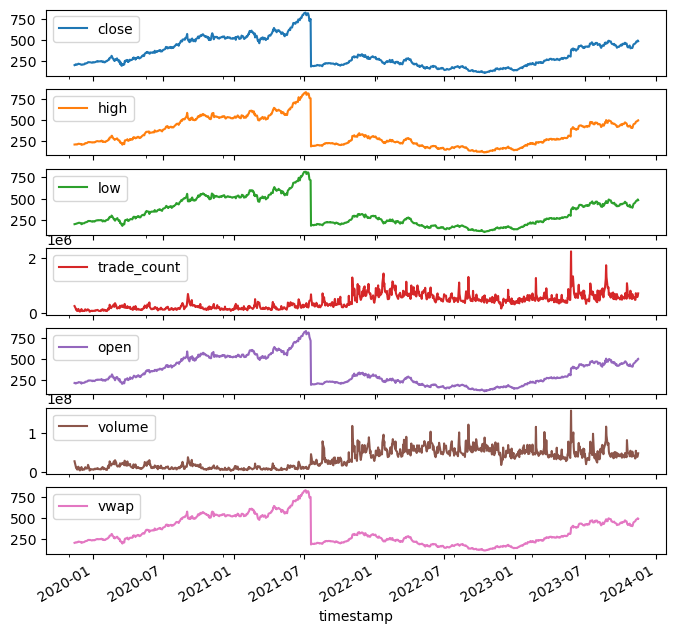

sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...


In [59]:
STOCK = "NVDA"

dataNVDA = get_stock_news_data(STOCK, START_DATE, END_DATE)

In [60]:
plot_close_news(dataNVDA)

In [61]:
finalDataNVDA = dataNVDA[["close", "positive", "negative", "neutral"]]

finalDataNVDA[["positive", "negative", "neutral"]] = finalDataNVDA[
    ["positive", "negative", "neutral"]
].astype(int)
finalDataNVDA


window = 60

batchSize = 30
features = finalDataNVDA.shape[1]

hiddenSize = 64
inputSize = 4
outputSize = 1
layerSize = 2
learningRate = 0.001
weightDecay = 1e-5
dropoutRate = 0.2

epochs = 20

(
    trainLoaderNVDA,
    valLoaderNVDA,
    testLoaderNVDA,
    scalerNVDA,
    testIndexNVDA,
) = preproc_data(finalDataNVDA, window, batchSize)

In [81]:
yValsNVDA = []
for seqs, target in valLoaderNVDA:
    yValsNVDA.extend(target.tolist())

baselinePredsNVDA = [np.mean(yValsNVDA)] * len(yValsNVDA)

baselineMetricsNVDA = calc_metrics(yValsNVDA, baselinePredsNVDA)
baselineMetricsNVDA

{'mae': 0.2028, 'rmse': 0.2295}

Training vanilla RNN network
Epoch 5
Epoch 10
Epoch 15
Epoch 20
------------------
Test Error: 
 Avg loss: 0.1028 



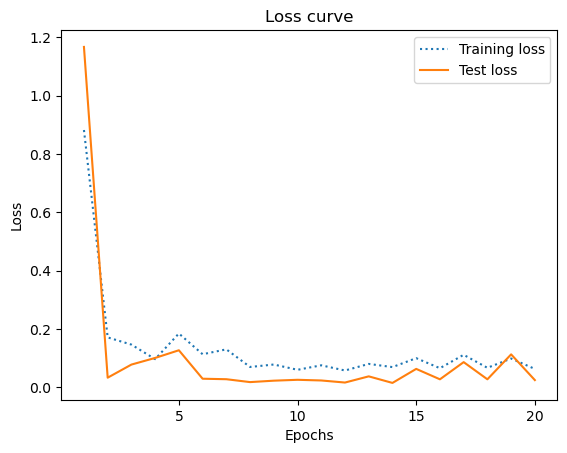

Training LSTM network
Epoch 5
Epoch 10
Epoch 15
Epoch 20
------------------
Test Error: 
 Avg loss: 0.1996 



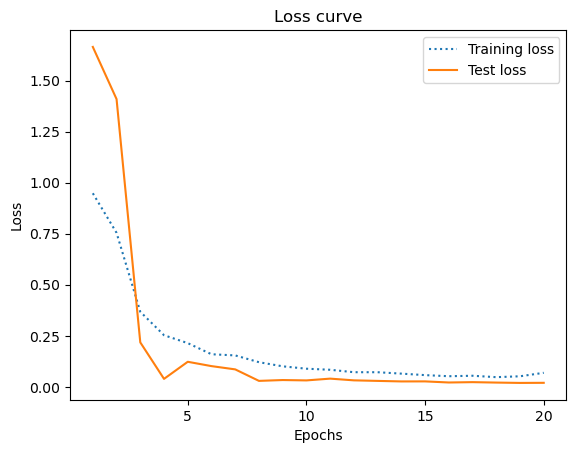

Training GRU network
Epoch 5
Epoch 10
Epoch 15
Epoch 20
------------------
Test Error: 
 Avg loss: 0.1596 



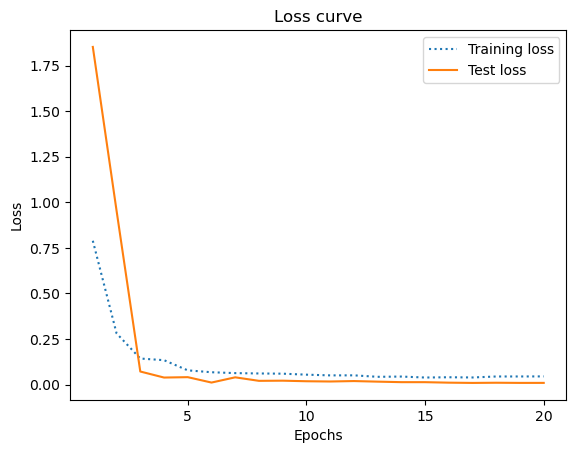

In [62]:
rnnNetNVDA, lstmNetNVDA, gruNetNVDA = training(
    trainLoaderNVDA,
    valLoaderNVDA,
    inputSize,
    hiddenSize,
    layerSize,
    outputSize,
    dropoutRate,
    learningRate,
    weightDecay,
    epochs,
)

In [64]:
test(valLoaderNVDA, rnnNetNVDA, nn.MSELoss(), check=True)

{'mae': 0.1321, 'rmse': 0.156}


{'val_loss': 0.0243}

In [65]:
test(valLoaderNVDA, lstmNetNVDA, nn.MSELoss(), check=True)

{'mae': 0.1125, 'rmse': 0.1403}


{'val_loss': 0.0197}

In [66]:
test(valLoaderNVDA, gruNetNVDA, nn.MSELoss(), check=True)

{'mae': 0.0783, 'rmse': 0.0952}


{'val_loss': 0.0091}

In [68]:
testDataPreds, testMetrics = inference(
    gruNetNVDA, testLoaderNVDA, scalerNVDA, testIndexNVDA
)

{'mae': 23.2322, 'rmse': 29.8178}


In [69]:
predPlot = make_subplots(specs=[[{"secondary_y": True}]])


predPlot.add_trace(
    go.Scatter(
        x=finalDataNVDA.index[-300:],
        y=finalDataNVDA["close"][-300:],
        marker_color="blue",
        name=STOCK + " Clasing price",
    )
)
predPlot.add_trace(
    go.Scatter(x=testDataPreds.index, y=testDataPreds["target"], name="Target"),
    secondary_y=False,
)
predPlot.add_trace(
    go.Scatter(x=testDataPreds.index, y=testDataPreds["prediction"], name="Prediction"),
    secondary_y=False,
)

predPlot.update_layout(
    title="Stock price prediction for " + STOCK,
)


predPlot.show()